## Imports

In [1]:
import config
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

# Teleportation

The quantum teleportation protocol is a fundamental part of many quantum algorithms. It enables you to transfer the state of one qubit to another qubit instantly. An important distinction to make is that teleportation in this context refers to the transfer of information rather than matter, since the qubits stay in the same place, but the state is transferred.

This protocol is useful to overcome the difficulties imposed by the [no-cloning theorem](https://en.wikipedia.org/wiki/No-cloning_theorem), which tells us that it is not possible to create an exact copy of a quantum state. Which means we cannot copy the state of one qubit into another, but we can teleport it. In fact, most uses of the teleportation protocol are to transfer the state of a qubit into another within a single QPU rather than across large distances like most sci-fi movies portray it. 

The circuit is composed the following way:

In [2]:
def teleportation(hardware = False):
    qreg_sender   = QuantumRegister(1, name='q_sender')
    qreg_ep       = QuantumRegister(1, name='q_ancillary')
    qreg_receiver = QuantumRegister(1, name='q_receiver')
    creg_receiver = ClassicalRegister(1, name='c_receiver')
    if not hardware:
        creg_ep       = ClassicalRegister(1, name='c_ancillary')
        creg_sender   = ClassicalRegister(1, name='c_sender')
        qc            = QuantumCircuit(qreg_sender, qreg_ep, qreg_receiver, creg_sender, creg_ep, creg_receiver)
    else:
        qc = QuantumCircuit(qreg_sender, qreg_ep, qreg_receiver, creg_receiver)

    # Entangle ep register with receiver register
    qc.h(qreg_ep)
    qc.cx(qreg_ep, qreg_receiver)

    qc.barrier()

    # Prepare qubit to be sent with specific state
    qc.reset(qreg_sender)
    qc.h(qreg_sender)
    qc.rz(np.pi/4, qreg_sender)
    qc.h(qreg_sender)

    qc.barrier()

    # Send qubit
    qc.cx(qreg_sender, qreg_ep)
    qc.h(qreg_sender)

    if not hardware:
        qc.measure(qreg_sender, creg_sender)
        qc.measure(qreg_ep, creg_ep)

        qc.barrier()

        # Receive qubit and apply gates depending on measures of sender's and entangled's qubits
        qc.x(qreg_receiver).c_if(creg_ep, 1)
        qc.z(qreg_receiver).c_if(creg_sender, 1)

        qc.barrier()
    else:
        qc.barrier()

        # Use conditional quantum gates instead of classical controlled gates
        qc.cx(qreg_ep, qreg_receiver)
        qc.cz(qreg_sender, qreg_receiver)

        qc.barrier()

    # Measure
    qc.h(qreg_receiver)
    qc.rz(-np.pi/4, qreg_receiver)
    qc.h(qreg_receiver)
    qc.measure(qreg_receiver, creg_receiver)

    # Return circuit
    return qc

In [3]:
circ = teleportation()
circ.draw()

░      ┌───┐┌─────────┐┌───┐ ░      ┌───┐┌─┐ ░ »
     q_sender: ───────────░──|0>─┤ H ├┤ Rz(π/4) ├┤ H ├─░───■──┤ H ├┤M├─░─»
               ┌───┐      ░      └───┘└─────────┘└───┘ ░ ┌─┴─┐└┬─┬┘└╥┘ ░ »
  q_ancillary: ┤ H ├──■───░────────────────────────────░─┤ X ├─┤M├──╫──░─»
               └───┘┌─┴─┐ ░                            ░ └───┘ └╥┘  ║  ░ »
   q_receiver: ─────┤ X ├─░────────────────────────────░────────╫───╫──░─»
                    └───┘ ░                            ░        ║   ║  ░ »
   c_sender: 1/═════════════════════════════════════════════════╬═══╩════»
                                                                ║   0    »
c_ancillary: 1/═════════════════════════════════════════════════╩════════»
                                                                0        »
 c_receiver: 1/══════════════════════════════════════════════════════════»
                                                                         »
«                              ░                          
«     q_sender: ───────────────░──────────────────────────
«                              ░                          
«  q_ancillary: ───────────────░──────────────────────────
«                ┌───┐  ┌───┐  ░ ┌───┐┌──────────┐┌───┐┌─┐
«   q_receiver: ─┤ X ├──┤ Z ├──░─┤ H ├┤ Rz(-π/4) ├┤ H ├┤M├
«                └─╥─┘  └─╥─┘  ░ └───┘└──────────┘└───┘└╥┘
«                  ║   ┌──╨──┐                          ║ 
«   c_sender: 1/═══╬═══╡ 0x1 ╞══════════════════════════╬═
«               ┌──╨──┐└─────┘                          ║ 
«c_ancillary: 1/╡ 0x1 ╞═════════════════════════════════╬═
«               └─────┘                                 ║ 
« c_receiver: 1/════════════════════════════════════════╩═
«                                                       0

$\newcommand\Hto{\xrightarrow{H}}\newcommand\Xto{\xrightarrow{X}}\newcommand\Zto{\xrightarrow{Z}}\newcommand\Htopsi{\xrightarrow{H|\psi\rangle}}\newcommand\Rzto{\xrightarrow{R_z}}\newcommand\Cnot{\xrightarrow{CNOT|\psi\phi\rangle}}$We define three states $|\psi\rangle$, $|\phi\rangle$, and $|\omega\rangle$. $|\psi\rangle$ will be the state we want to send, $|\phi\rangle$ will be an ancillary qubit, and $|\omega\rangle$ will be the qubit to which we want to send the state originally in $|\psi\rangle$.

$$ |\psi\rangle\textrm{: sender qubit, } \: |\phi\rangle\textrm{: ancillary qubit, } \: |\omega\rangle\textrm{: receiver qubit.} $$

As you can see, the first thing we do is entangle $|\phi\rangle$ with $|\omega\rangle$. This gives us the state:

\begin{equation} \label{eq:first_entanglement}
    |\psi\rangle \otimes \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) \tag{1}
\end{equation}

Note that in this equation and onward, we will describe our state as $|\psi\phi\omega\rangle$. For example, the state $|010\rangle$ means that $|\psi\rangle = |0\rangle$, $|\phi\rangle = |1\rangle$, and $|\omega\rangle = |0\rangle$. After entangling $|\phi\rangle$ and $|\omega\rangle$, we prepare $|\psi\rangle$ to the state we want to send. Let's now focus on this state and how it will result after applying the corresponding gates. 

\begin{align}
    |\psi\rangle = |0\rangle &\Hto \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \\
    &\Rzto{}  \frac{1}{\sqrt{2}}\left(e^{-i\frac{\pi}{8}}|0\rangle + e^{i\frac{\pi}{8}}|1\rangle\right) \\ 
    &\Hto{} \frac{1}{2}\left(e^{-i\frac{\pi}{8}}(|0\rangle + |1\rangle) + e^{i\frac{\pi}{8}}(|0\rangle-|1\rangle)\right) = \cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \label{eq:prepare_send_state} \tag{2}
\end{align}

The simplified state at \eqref{eq:prepare_send_state} is the one we will be sending to $|\omega\rangle$. Now, we are going to entangle $|\psi\rangle$ with $|\phi\rangle$ using a CNOT gate and then we are going to send $|\psi\rangle$ through a Hadamard gate. Before applying any gates, let's see our state up to here. We can found this state by replacing $|\psi\rangle$ in \eqref{eq:first_entanglement} with the state for $|\psi\rangle$ we got in \eqref{eq:prepare_send_state}. 

\begin{align} \label{eq:expanded_state}
    \left(\cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle\right) \otimes \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right) = \frac{1}{\sqrt{2}}\left(\cos{\frac{\pi}{8}}(|000\rangle + |011\rangle) - \sin{\frac{\pi}{8}}(|100\rangle + |111\rangle)\right) \tag{3}
\end{align}

First we are going to send our state through the CNOT gate, where $|\psi\rangle$ acts as the control qubit and $|\phi\rangle$ as the target qubit, and then we are going to send $|\psi\rangle$ through a Hadamard gate. The following equations describe this operations. For simplicity, we will denote the state we are starting with as $|\psi\phi\omega\rangle$, this state is the one we ended up with in \eqref{eq:expanded_state}.

\begin{align}
     |\psi\phi\omega\rangle &\Cnot{} \frac{1}{\sqrt{2}}\left(\cos{\frac{\pi}{8}}(|000\rangle + |011\rangle) - \sin{\frac{\pi}{8}}(|110\rangle + |101\rangle)\right) \\ 
     &\Htopsi{} \frac{1}{2}\left(\cos{\frac{\pi}{8}} (|000\rangle + |100\rangle + |011\rangle + |111\rangle) - \sin{\frac{\pi}{8}}(|010\rangle - |110\rangle + |001\rangle - |101\rangle) \right) \label{before_measuring} \tag{4}
\end{align}

Here it gets a little bit tricky, since we are going to measure $|\psi\rangle$ and $|\phi\rangle$. As you may know, there are 4 possible states we might end up with, these are $|00\rangle$, $|01\rangle$, $|10\rangle$ and $|11\rangle$. And for each of this four states, you can have either $|0\rangle$ or $|1\rangle$ for our last qubit: $|\omega\rangle$. This gives us the 8 possible states we can see in \eqref{before_measuring}. Since we are only going to measure the first two qubits, $|\omega\rangle$ will remain in a superposition of states, we will examine the 4 possibilities in the following equations:

\begin{align}
    \textrm{When} \: |\psi\phi\rangle=|00\rangle \textrm{, } |\omega\rangle&=\cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \\
    \textrm{When} \: |\psi\phi\rangle=|01\rangle \textrm{, } |\omega\rangle&=-\sin{\frac{\pi}{8}}|0\rangle + \cos{\frac{\pi}{8}}|1\rangle \\
    \textrm{When} \: |\psi\phi\rangle=|10\rangle \textrm{, } |\omega\rangle&=\cos{\frac{\pi}{8}}|0\rangle + \sin{\frac{\pi}{8}}|1\rangle \\
    \textrm{When} \: |\psi\phi\rangle=|11\rangle \textrm{, } |\omega\rangle&=\sin{\frac{\pi}{8}}|0\rangle + \cos{\frac{\pi}{8}}|1\rangle
\end{align}

Now, as you can see in the circuit, we are going to send $|\omega\rangle$ through some gates depending on the measurements we made. We are going to apply a Pauli-X gate if $|\phi\rangle = |1\rangle$, followed by a Pauli-Z gate if $|\psi\rangle=|1\rangle$. After applying this conditional gates, $|\omega\rangle$ should be in the state of $|\psi\rangle$ showed in \eqref{eq:prepare_send_state}, meaning that the teleportation was completed successfully. Let's see what happens exactly in each case, we will start with the case in which $|\psi\phi\rangle=|00\rangle$. Well, in this case no further gate is applied, we just have the following state.

\begin{equation} \label{eq:first_case}
    |\omega\rangle = \cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \tag{5}
\end{equation}

Now, let's look at what happens when $|\psi\phi\rangle=|01\rangle$. We will only apply a Pauli-X gate. 

\begin{align} \label{eq:second_case}
    |\omega\rangle=-\sin{\frac{\pi}{8}}|0\rangle + \cos{\frac{\pi}{8}}|1\rangle \Xto{} \cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \tag{6}
\end{align}

Now, we look at the case where $|\psi\phi\rangle=|10\rangle$. In this case, we only apply a Pauli-Z gate. 

\begin{align} \label{eq:third_case}
    |\omega\rangle=\cos{\frac{\pi}{8}}|0\rangle + \sin{\frac{\pi}{8}}|1\rangle \Zto{} \cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \tag{7}
\end{align}

Finally, we look at what happens when $|\psi\phi\rangle=|11\rangle$. This time, we apply a Pauli-X gate followed by a Pauli-Z gate.

\begin{align} 
    |\omega\rangle=\sin{\frac{\pi}{8}}|0\rangle + \cos{\frac{\pi}{8}}|1\rangle &\Xto{} \cos{\frac{\pi}{8}}|0\rangle + \sin{\frac{\pi}{8}}|1\rangle \\
    &\Zto{} \cos{\frac{\pi}{8}}|0\rangle - \sin{\frac{\pi}{8}}|1\rangle \label{eq:fourth_case} \tag{8}
\end{align}

At this point, the quantum teleportation protocol is over. $|\omega\rangle$ is in the state we showed on \eqref{eq:prepare_send_state}, meaning that we successfully sent the state from $|\psi\rangle$ into $|\omega\rangle$. To achieve this, we needed to send two bits of information through classical channels, which allowed us to perform the controlled operations showed in \eqref{eq:first_case}, \eqref{eq:second_case}, \eqref{eq:third_case}, and \eqref{eq:fourth_case}. It is common to think that this use of classical channels throws away the whole purpose of teleporting a quantum state, but it really doesn't. This classical communication is really the only way of ensuring that we teleport the state successfully; if we didn't apply this step, we would be stuck with one of the four possibilities shown above without the person that has $|\omega\rangle$ having a clue about what $|\psi\phi\rangle$ is, therefore this person would only have the intended state $1/4$ of the time.

In the circuit shown earlier in this notebook, we apply some additional gates to $|\omega\rangle$. This is just a way to ensure that the teleportation protocol was successful when running in IBM's quantum computers. As you can see, this gates are the same that were applied to the state $|\psi\rangle$ when preparing it, but backwards (which turns out to be the same in this case). As you may know, quantum computation is reversible, so performing this operations will turn $|\omega\rangle$ back to the state $|0\rangle$ (we are applying the operations shown in \eqref{eq:prepare_send_state} but in reverse). This makes it easier to measure if the protocol was successful since the computer will measure $|\omega\rangle$ to be $|0\rangle$ with certainty (without taking into account noise of actual quantum hardware). 

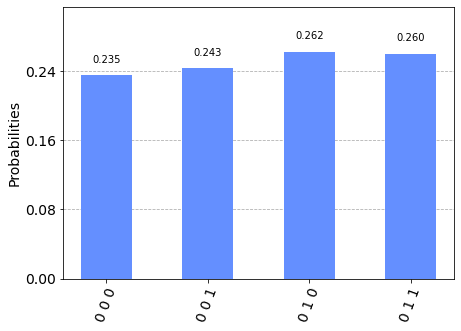

In [7]:
backend = Aer.get_backend('qasm_simulator')
result  = execute(circ, backend, shots=1024).result()
counts  = result.get_counts(circ)

plot_histogram(counts)

Notice that $|\omega\rangle$ is the first bit of the strings included in the histogram above.

### Running on hardware

Running this circuit on hardware requires some modifications, which makes the circuit look like the following

In [5]:
h_circ = teleportation(hardware = True)
h_circ.draw()

░      ┌───┐┌─────────┐┌───┐ ░      ┌───┐ ░         »
    q_sender: ───────────░──|0>─┤ H ├┤ Rz(π/4) ├┤ H ├─░───■──┤ H ├─░───────■─»
              ┌───┐      ░      └───┘└─────────┘└───┘ ░ ┌─┴─┐└───┘ ░       │ »
 q_ancillary: ┤ H ├──■───░────────────────────────────░─┤ X ├──────░───■───┼─»
              └───┘┌─┴─┐ ░                            ░ └───┘      ░ ┌─┴─┐ │ »
  q_receiver: ─────┤ X ├─░────────────────────────────░────────────░─┤ X ├─■─»
                   └───┘ ░                            ░            ░ └───┘   »
c_receiver: 1/═══════════════════════════════════════════════════════════════»
                                                                             »
«               ░                          
«    q_sender: ─░──────────────────────────
«               ░                          
« q_ancillary: ─░──────────────────────────
«               ░ ┌───┐┌──────────┐┌───┐┌─┐
«  q_receiver: ─░─┤ H ├┤ Rz(-π/4) ├┤ H ├┤M├
«               ░ └───┘└──────────┘└───┘└╥┘
«c_receiver: 1/══════════════════════════╩═
«                                        0

As you can see, the gates that changed are the ones that were conditioned in a classical bit. This types of gates are not available currently in IBM's computers, so we need to change them in order to run the circuit on them. It's quite easy to overcome this difficulty, since we can condition the gates with the corresponding qubits (this time without measuring) and we will get the same result. However, we lose the advantage that we haved where the only connection between the sender and the receiver was at the beggining to split the entangled qubits and afterwards through classical channels. Now, the whole quantum circuit has to be connected. Read more about this [here](https://qiskit.org/textbook/ch-algorithms/teleportation.html#5.-Teleportation-on-a-Real-Quantum-Computer-).